### Create boundary conditions based on observational datasets

For present day experiment. Observations from B-SOSE (http://sose.ucsd.edu/) and WOA. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import glob
import cmocean
import imageio
import pickle

#### Functions

In [2]:
def prepare_plot(subs=None, figsize=(15, 15)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    # To make circular maps:
    theta = np.linspace(0, 2*np.pi, 100)
    map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

    if subs:
        fig, ax = plt.subplots(subs[0], subs[1], figsize=figsize, subplot_kw={'projection': ccrs.SouthPolarStereo()})
        for axis in ax.ravel():
            axis.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
            axis.set_boundary(map_circle, transform=axis.transAxes)
            gl = axis.gridlines(draw_labels=True, ylocs=[]);
    else:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
        ax.set_boundary(map_circle, transform=ax.transAxes)
        gl = ax.gridlines(draw_labels=True, ylocs=[]);
    return fig, ax

In [32]:
def create_animation(dataset, variable1, variable2, depth_level, filename=None, vmin=33, vmax=35.5):
    fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

    cm1 = ax[0].pcolormesh(dataset.lon, dataset.lat, dataset[variable1].isel(time=0, depth=depth_level),
                           transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    cm2 = ax[1].pcolormesh(dataset.lon, dataset.lat, dataset[variable2].isel(time=0, depth=depth_level),
                           transform=ccrs.PlateCarree(), vmin=0, vmax=8)
    
    ax[0].set_title(dataset[variable1].standard_name)
    ax[1].set_title(dataset[variable2].standard_name)
    ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
    ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
    
    CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=dataset[variable1].long_name)
    CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=dataset[variable2].long_name)

    fig.suptitle(f'Depth {dataset.depth.values[depth_level]} m', fontweight='bold');
    
    if filename:
        fig.savefig(f'{filename}')

    plt.close()
    return

#### Load files

In [4]:
folder_WOA = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/'

In [5]:
# World Ocean Atlas files:
folder_WOA = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/'

WOA_sal = xr.Dataset(); WOA_temp = xr.Dataset(); 
for month in range(0,1):
    WOA_sadd = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', decode_times=False).sel(lat=slice(-90, -45))
    WOA_tadd = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', decode_times=False)
    WOA_sal  = WOA_sal.merge(WOA_sadd)
    WOA_temp = WOA_temp.merge(WOA_tadd)

In [ ]:
folder_SOSE  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/'
SOSE_uvel    = xr.open_dataset(f'{folder_SOSE}Uvel_bsoseI139_2013to2021_5dy.nc')
SOSE_vvel    = xr.open_dataset(f'{folder_SOSE}Vvel_bsoseI139_2013to2021_5dy.nc')
SOSE_sal     = xr.open_dataset(f'{folder_SOSE}Salt_bsoseI139_2013to2021_5dy.nc')
SOSE_temp    = xr.open_dataset(f'{folder_SOSE}Theta_bsoseI139_2013to2021_5dy.nc ')
SOSE_SSH     = xr.open_dataset(f'{folder_SOSE}SSH_bsoseI139_2013to2021_5dy.nc')
SSH_ice_dz   = xr.open_dataset(f'{folder_SOSE}SeaIceHeff_bsoseI139_2013to2021_5dy.nc')
SSH_ice_area = xr.open_dataset(f'{folder_SOSE}SeaIceArea_bsoseI139_2013to2021_5dy.nc')

### Explore

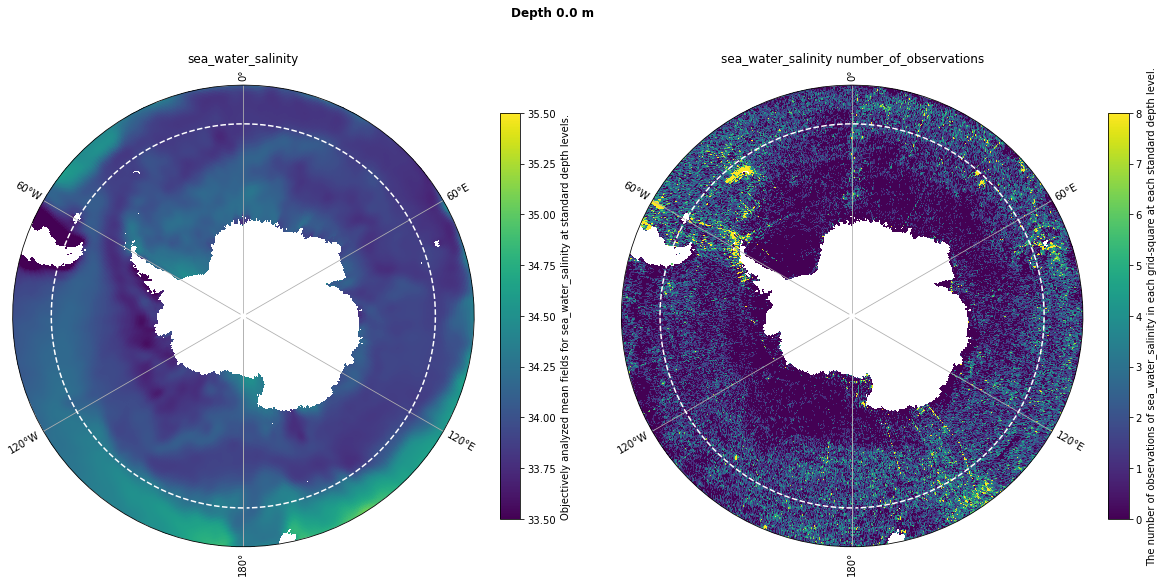

In [34]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=33.5, vmax=35.5)
cm2 = ax[1].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_dd.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_sal.s_an.standard_name)
ax[1].set_title(WOA_sal.s_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_sal.s_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_sal.s_dd.long_name)

fig.suptitle(f'Depth {WOA_sal.depth.values[0]} m', fontweight='bold');

In [ ]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=-2, vmax=4)
cm2 = ax[1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_dd.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_temp.t_an.standard_name)
ax[1].set_title(WOA_temp.t_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_temp.t_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_temp.t_dd.long_name)

fig.suptitle(f'Depth {WOA_temp.depth.values[20]} m', fontweight='bold');

In [36]:
for depth in range(0, len(WOA_sal.depth)):
    create_animation(WOA_sal, 's_an', 's_dd', depth, vmin=33.5, vmax=35.5,
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/sal_depth_animation/s_an_dd_{depth:03}.jpg')

KeyboardInterrupt: 

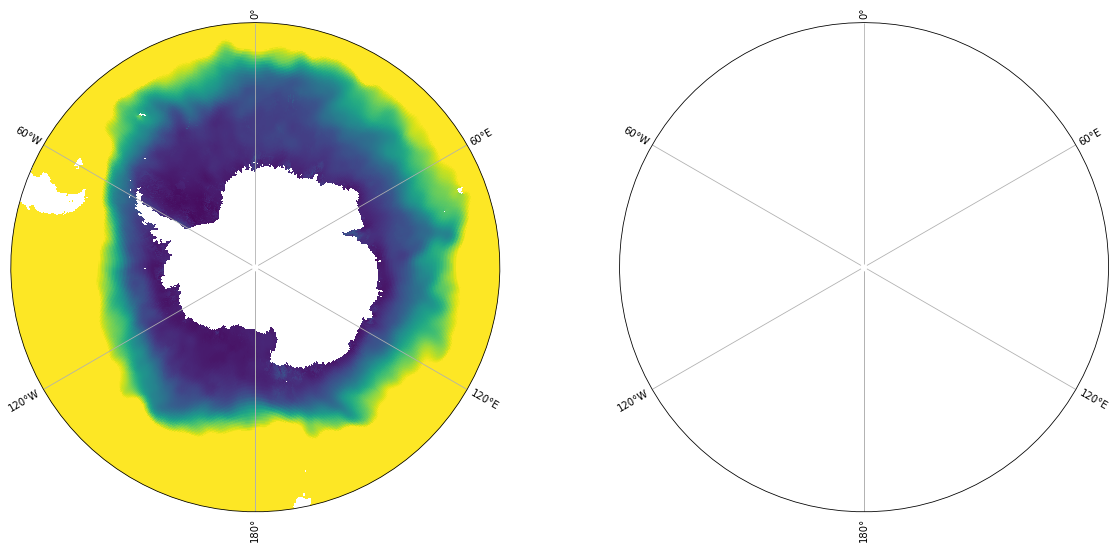

In [31]:
for depth in range(0, len(WOA_temp.depth)):
    create_animation(WOA_temp, 't_an', 't_dd', depth, vmin=-2, vmax=4, 
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/temp_depth_animation/t_an_dd_{depth:03}.jpg')